# Machine Learning - Exercise 2: Implementation

### 2.1 KNNRegressor

## 1 Import modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import time
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io.arff import loadarff

## 2 Algorithm implementation

In [2]:
class KNNRegressor:
    # constructor - hyperparameters k and distance function
    def __init__(self, k=5, distance_function="minkowski", p=2):
        self.k = k
        self.distance_function = distance_function
        self.p = p

    # fit method - define features and target variable
    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values

    # predict method - get prediction for each point
    def predict(self, X):
        predictions = [self._predict_point(x) for x in X.values]
        return np.array(predictions)
    
    # calculate prediction for specific point
    def _predict_point(self, x):
        if self.distance_function == "euclidean":
            distances = [self._euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_function == "manhattan":
            distances = [self._manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_function == "chebyshev":
            distances = [self._chebyshev_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_function == "minkowski":
            distances = [self._minkowski_distance(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError("Invalid distance function specified.")
            
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_values = [self.y_train[i] for i in k_indices]
        return np.mean(k_nearest_values)
    
    # methods that implement different distance functions
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))
    def _manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))
    def _chebyshev_distance(self, x1, x2):
        return np.max(np.abs(x1 - x2))
    def _minkowski_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2) ** self.p) ** (1/self.p)

### 2.2 Gradient Descent

In [3]:
# Gradient Descent for Linear Regression
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        m, n = X.shape  # m: number of samples, n: number of features
        self.theta = np.zeros(n)  # initialize weights to zeros
        self.bias = 0  # initialize bias to zero
        for i in range(self.n_iterations):
            y_pred = np.dot(X, self.theta) + self.bias  # hypothesis function
            error = y_pred - y  # error term
            gradient_theta = (1 / m) * np.dot(X.T, error)  # gradient with respect to theta
            gradient_bias = (1 / m) * np.sum(error)  # gradient with respect to bias
            # update parameters
            self.theta -= self.learning_rate * gradient_theta
            self.bias -= self.learning_rate * gradient_bias

    def predict(self, X):
        return np.dot(X, self.theta) + self.bias  # predict using the learned parameters

## 3 Datasets preparation

### 3.1 Load the datasets

In [4]:
df_bodyfat = pd.read_csv("bodyfat.csv")
df_ds_salary = pd.read_csv("ds_salaries.csv")
data, meta = loadarff('cpu.arff')
df_cpu = pd.DataFrame(data)

### 3.2 Preprocessing

In [5]:
# Bodyfat
df_bodyfat.drop(columns=['id'], inplace=True)

# Data Science Salary
df_ds_salary.drop(columns=['Unnamed: 0', 'salary', 'salary_currency'], inplace=True)
df_ds_salary.rename(columns={'salary_in_usd': 'class'}, inplace=True)
categorical_columns = df_ds_salary.select_dtypes(include=['object']).columns
for column in categorical_columns:
    one_hot_encoded = pd.get_dummies(df_ds_salary[column], prefix=column)
    df_ds_salary = pd.concat([df_ds_salary, one_hot_encoded], axis=1)
    df_ds_salary.drop(columns=[column], inplace=True)

# CPU
df_cpu.rename(columns={'usr': 'class'}, inplace=True)
missing_values = df_cpu.isnull().sum() # no missing values


### 3.3 Data Sets Split

In [6]:
def split_data(df, target_column='class', test_size=0.2, random_state=98):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train_bodyfat, X_test_bodyfat, y_train_bodyfat, y_test_bodyfat = split_data(df_bodyfat)
X_train_ds_salary, X_test_ds_salary, y_train_ds_salary, y_test_ds_salary = split_data(df_ds_salary)
X_train_CPU, X_test_CPU, y_train_CPU, y_test_CPU = split_data(df_cpu)


### 3.4 Scalling data

In [7]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test) 
    return pd.DataFrame(scaled_X_train, columns=X_train.columns), pd.DataFrame(scaled_X_test, columns=X_test.columns)

scaledX_train_bodyfat, scaledX_test_bodyfat = scale_data(X_train_bodyfat, X_test_bodyfat)
scaledX_train_ds_salary, scaledX_test_ds_salary = scale_data(X_train_ds_salary, X_test_ds_salary)
scaledX_train_CPU, scaledX_test_CPU = scale_data(X_train_CPU, X_test_CPU)

## 4 Modeling and evaluation

In [9]:
pd.options.display.float_format = '{:.4f}'.format
datasets = {
    "df_bodyfat": (scaledX_train_bodyfat, y_train_bodyfat, scaledX_test_bodyfat, y_test_bodyfat),
    "df_ds_salary": (scaledX_train_ds_salary, y_train_ds_salary, scaledX_test_ds_salary, y_test_ds_salary),
    "df_CPU": (scaledX_train_CPU, y_train_CPU, scaledX_test_CPU, y_test_CPU),
}

### 4.1 Finding best parameter settings

In [10]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

#### 4.1.1 KNNRegressor

##### 4.1.2.1 K-neighbours

Evaluating df_bodyfat
k: 1 - MSE: 21.377254901960786, MAE: 3.486274509803921
k: 2 - MSE: 16.392450980392155, MAE: 3.250980392156863
k: 3 - MSE: 11.867211328976035, MAE: 2.6934640522875815
k: 4 - MSE: 11.526678921568626, MAE: 2.7759803921568627
k: 5 - MSE: 10.183905882352946, MAE: 2.590588235294118
k: 6 - MSE: 10.045299564270152, MAE: 2.5990196078431373
k: 7 - MSE: 10.615238095238096, MAE: 2.5619047619047617
k: 8 - MSE: 10.570315563725494, MAE: 2.4948529411764704
k: 9 - MSE: 10.74853304284677, MAE: 2.5135076252723314
k: 10 - MSE: 10.710666666666667, MAE: 2.4631372549019606
k: 11 - MSE: 10.942790471560523, MAE: 2.5379679144385032
k: 12 - MSE: 11.937633442265797, MAE: 2.6931372549019605
k: 13 - MSE: 12.819059055574893, MAE: 2.7886877828054293
k: 14 - MSE: 12.985078031212485, MAE: 2.8352941176470594
k: 15 - MSE: 12.314419172113286, MAE: 2.776732026143791
k: 16 - MSE: 12.840451133578428, MAE: 2.852083333333333
k: 17 - MSE: 12.58792048307212, MAE: 2.854671280276817
k: 18 - MSE: 12.8415359477

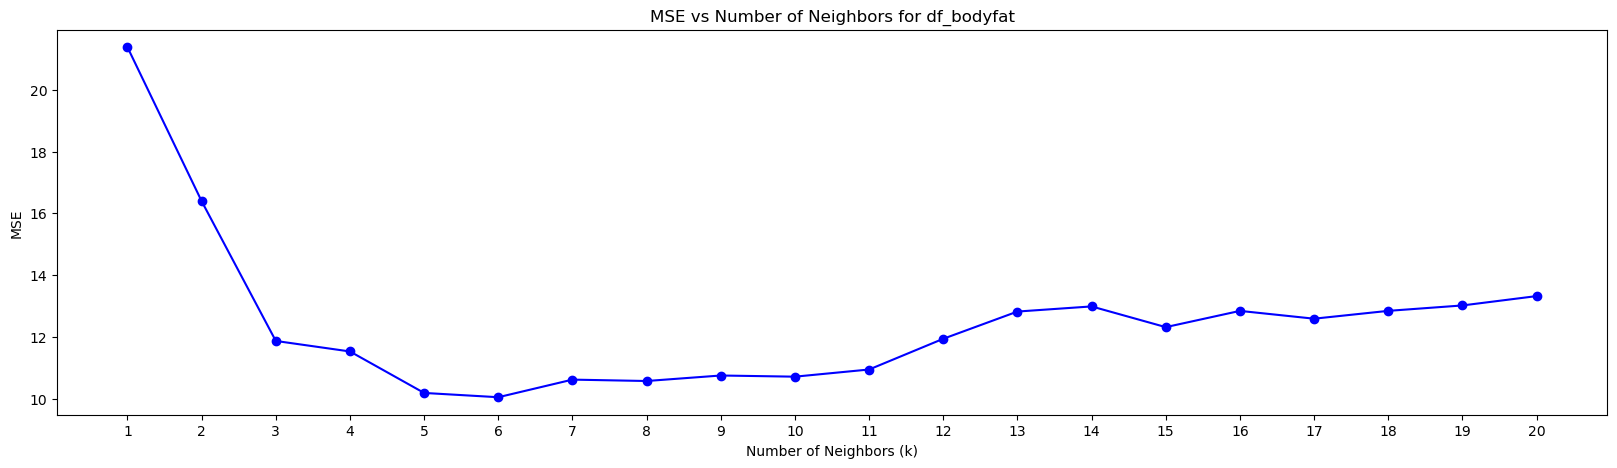

Evaluating df_ds_salary
k: 1 - MSE: 6114433530.696721, MAE: 53533.188524590165
k: 2 - MSE: 4620323436.6495905, MAE: 47691.99590163935
k: 3 - MSE: 4386182432.554645, MAE: 45655.3087431694
k: 4 - MSE: 4222929256.6116805, MAE: 45034.94672131148
k: 5 - MSE: 4112248137.5098357, MAE: 44917.39836065574
k: 6 - MSE: 4007800537.1489067, MAE: 44738.94535519125
k: 7 - MSE: 4015662038.478421, MAE: 45118.36533957846
k: 8 - MSE: 3990407149.328381, MAE: 44942.065573770495
k: 9 - MSE: 4024776461.5806518, MAE: 45491.870673952646
k: 10 - MSE: 4060131749.3718033, MAE: 45400.80163934426
k: 11 - MSE: 4088525656.199905, MAE: 45468.289865871826
k: 12 - MSE: 4031530927.495332, MAE: 45484.4849726776
k: 13 - MSE: 3991805777.3805413, MAE: 45130.872635561165
k: 14 - MSE: 3973699840.7851706, MAE: 45325.23243559718
k: 15 - MSE: 4013583612.6258655, MAE: 45728.60327868852
k: 16 - MSE: 4059959086.5997376, MAE: 46140.74743852459
k: 17 - MSE: 4034501680.086193, MAE: 46177.12680810028
k: 18 - MSE: 4033220921.1516395, MAE:

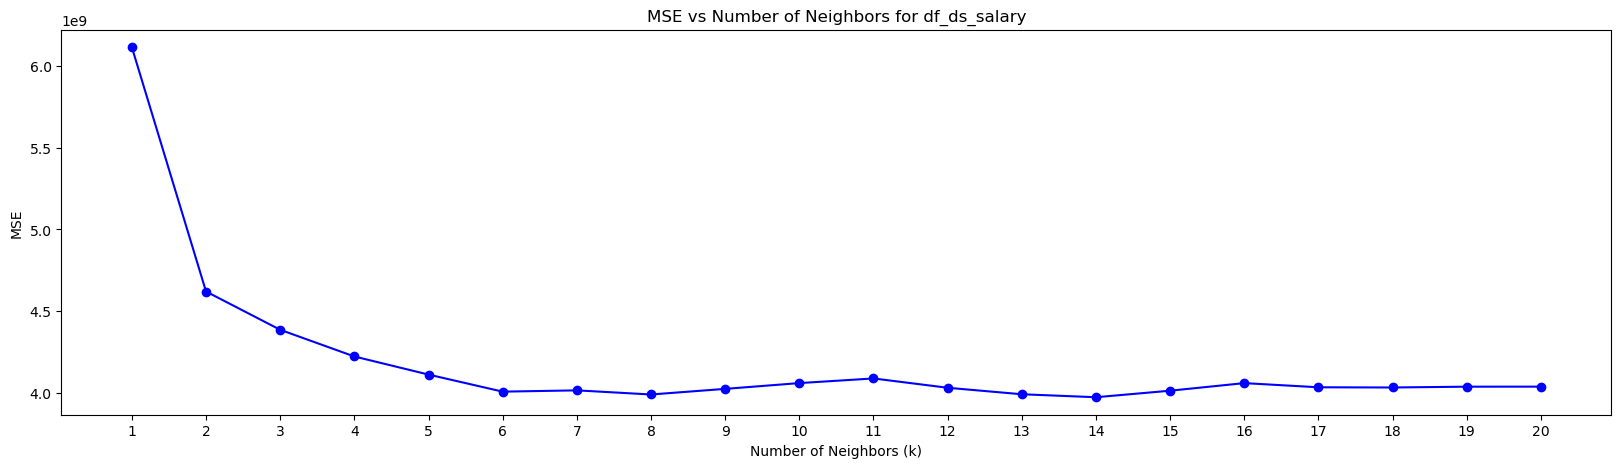

Evaluating df_CPU
k: 1 - MSE: 18.767541183648568, MAE: 2.8078096400244053
k: 2 - MSE: 15.747406955460647, MAE: 2.4917632702867603
k: 3 - MSE: 14.530133550267779, MAE: 2.3644498678055723
k: 4 - MSE: 14.644028370957901, MAE: 2.3329774252593043
k: 5 - MSE: 14.96170835875534, MAE: 2.3070164734594267
k: 6 - MSE: 15.587485594197, MAE: 2.2900142363229614
k: 7 - MSE: 15.620612369413902, MAE: 2.288067637060925
k: 8 - MSE: 16.056560784014643, MAE: 2.2869890176937155
k: 9 - MSE: 16.656226696495153, MAE: 2.3008609585790794
k: 10 - MSE: 17.606131787675412, MAE: 2.3190359975594874
k: 11 - MSE: 18.51753488067205, MAE: 2.3453879860225193
k: 12 - MSE: 19.321279065826047, MAE: 2.3595179987797437
k: 13 - MSE: 19.93583546035792, MAE: 2.3641526258975927
k: 14 - MSE: 20.745663732240914, MAE: 2.3849908480780964
k: 15 - MSE: 21.576432784218017, MAE: 2.392800488102502
k: 16 - MSE: 21.773015653599757, MAE: 2.3973078096400244
k: 17 - MSE: 21.99651445834767, MAE: 2.4070990202060085
k: 18 - MSE: 21.814133128450802

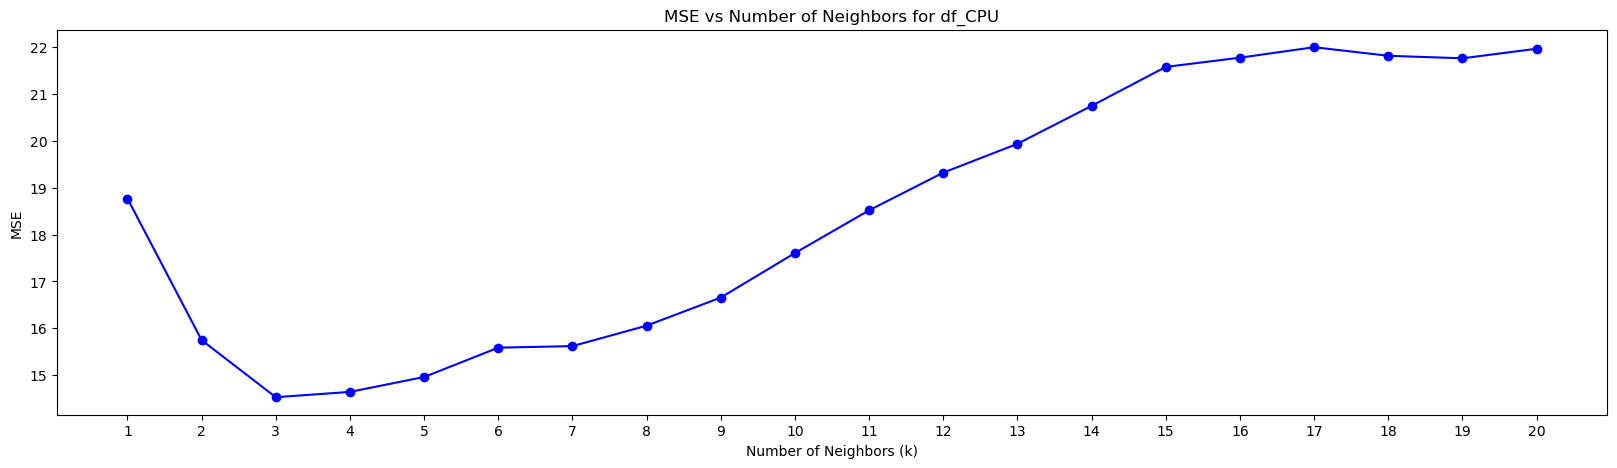

In [17]:
# Define the range of k values
k_values = np.arange(1, 21, 1)
fixed_distance_function = 'euclidean'  # Fixed distance function 

# Function to evaluate the model with different k values
def evaluate_k_values(scaledX_train, y_train, scaledX_test, y_test, distance_function, k_values):
    results = []

    for k_val in k_values:
        model_knn = KNNRegressor(k=k_val, distance_function=distance_function)
        model_knn.fit(scaledX_train, y_train)
        y_pred_knn = model_knn.predict(scaledX_test)

        mse_knn = mean_squared_error(y_test, y_pred_knn)
        mae_knn = mean_absolute_error(y_test, y_pred_knn)
        results.append((k_val, mse_knn, mae_knn))
        print(f"k: {k_val} - MSE: {mse_knn}, MAE: {mae_knn}")

    return results


# Evaluate and plot results for each dataset
for dataset_name, (scaledX_train, y_train, scaledX_test, y_test) in datasets.items():
    print(f"Evaluating {dataset_name}")
    results_knn = evaluate_k_values(scaledX_train, y_train, scaledX_test, y_test, fixed_distance_function, k_values)

    # Extract results for plotting
    k_values_res = [r[0] for r in results_knn]
    mse_res_knn = [r[1] for r in results_knn]

    # Plotting MSE against k values
    plt.figure(figsize=(20, 5))
    plt.plot(k_values_res, mse_res_knn, 'bo-')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('MSE')
    plt.title(f'MSE vs Number of Neighbors for {dataset_name}')

    # Set x-axis ticks to integers
    plt.xticks(k_values_res)

    plt.show()

#### 4.1.2.2 Distance function

Evaluating df_bodyfat
Distance Function: euclidean - MSE: 10.183905882352946, MAE: 2.590588235294118
Distance Function: manhattan - MSE: 13.033105882352938, MAE: 2.8294117647058825
Distance Function: chebyshev - MSE: 13.293662745098036, MAE: 2.8149019607843133
Distance Function: minkowski - MSE: 9.861333333333334, MAE: 2.5294117647058827


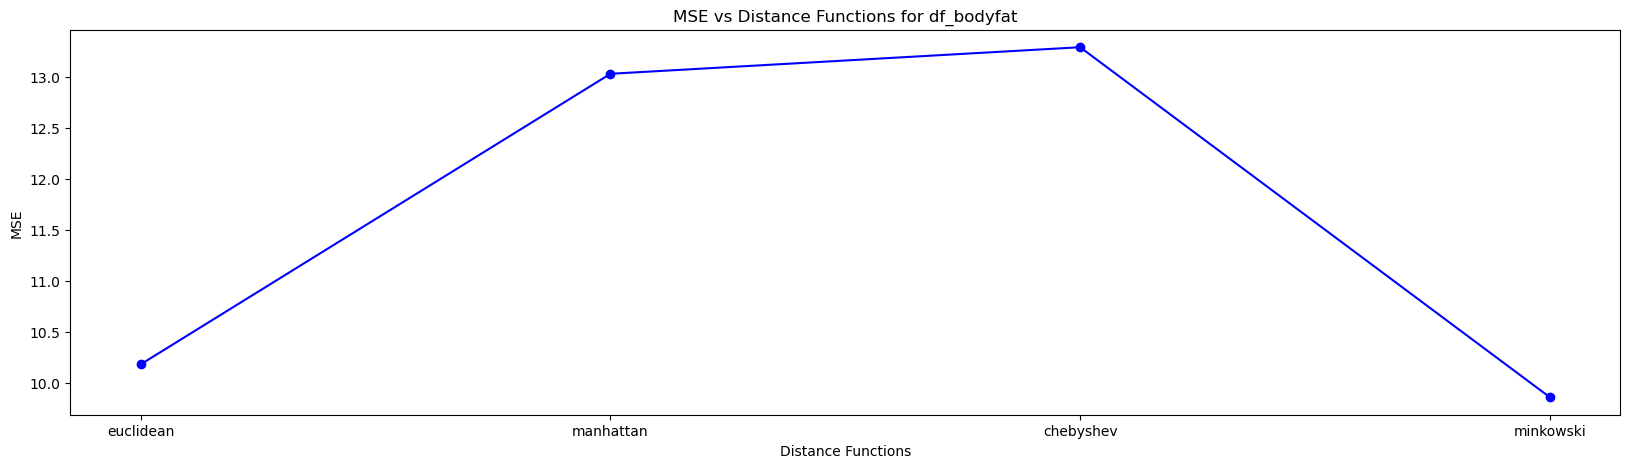

Evaluating df_ds_salary
Distance Function: euclidean - MSE: 4112248137.5098357, MAE: 44917.39836065574
Distance Function: manhattan - MSE: 4058416746.5947547, MAE: 44838.452459016386
Distance Function: chebyshev - MSE: 4072685100.40459, MAE: 45493.59344262295
Distance Function: minkowski - MSE: 4382400118.76918, MAE: 46316.5475409836


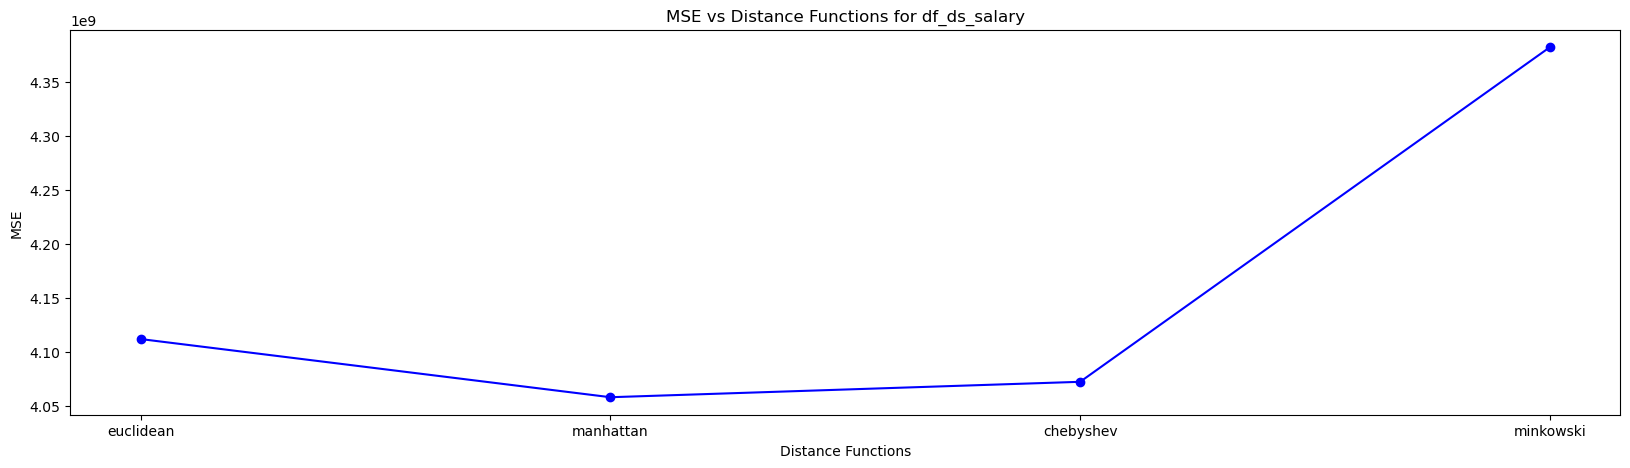

Evaluating df_CPU
Distance Function: euclidean - MSE: 14.96170835875534, MAE: 2.3070164734594267
Distance Function: manhattan - MSE: 11.278779743746185, MAE: 2.126662599145821
Distance Function: chebyshev - MSE: 17.035485051860892, MAE: 2.4347773032336795
Distance Function: minkowski - MSE: 15.409957291031116, MAE: 2.3476510067114096


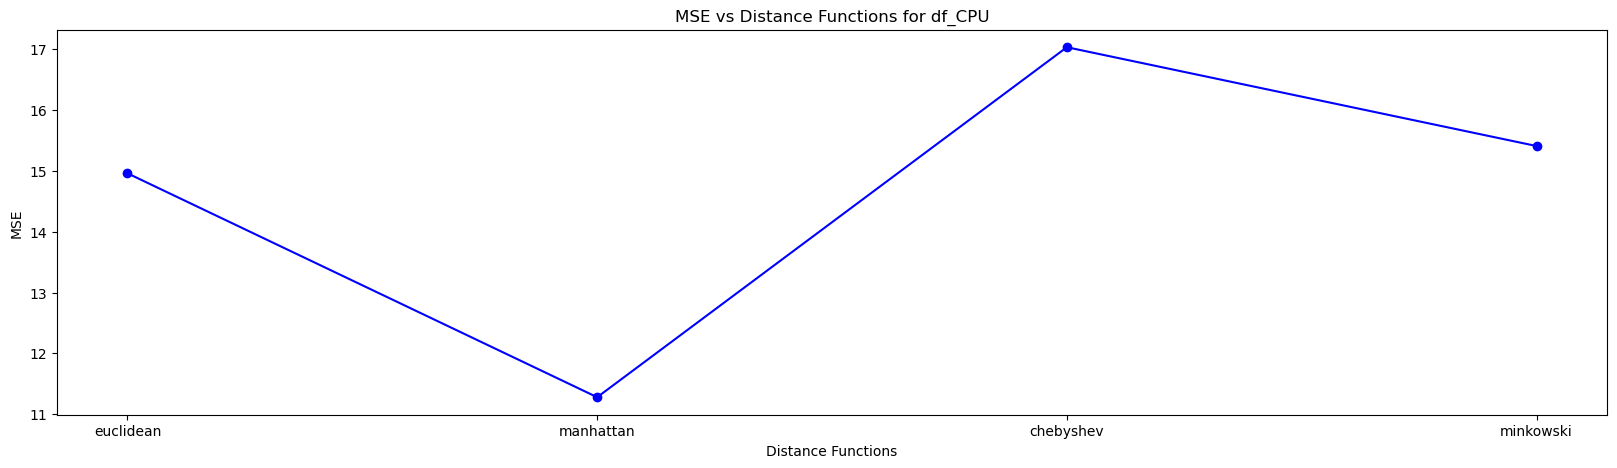

In [18]:
# Fixed k value
k_value = 5

# List of distance functions
distance_functions = {
    'euclidean': 'euclidean',
    'manhattan': 'manhattan',
    'chebyshev': 'chebyshev',
    'minkowski': 'minkowski'
}

# Fixed p for minkowski distance
p_value = 3 

# Function to evaluate the model with different distance functions
def evaluate_distance_functions(scaledX_train, y_train, scaledX_test, y_test, k_value, distance_functions, p_value): 
    results = []

    for name, function in distance_functions.items():
        model_knn = KNNRegressor(k=k_value, distance_function=function, p=p_value) 
        model_knn.fit(scaledX_train, y_train)
        y_pred_knn = model_knn.predict(scaledX_test)

        mse_knn = mean_squared_error(y_test, y_pred_knn)
        mae_knn = mean_absolute_error(y_test, y_pred_knn)
        results.append((name, mse_knn, mae_knn))
        print(f"Distance Function: {name} - MSE: {mse_knn}, MAE: {mae_knn}")

    return results


# Evaluate and plot results for each dataset
for dataset_name, (scaledX_train, y_train, scaledX_test, y_test) in datasets.items():
    print(f"Evaluating {dataset_name}")
    results_knn = evaluate_distance_functions(scaledX_train, y_train, scaledX_test, y_test, k_value, distance_functions, p_value) 

    # Extract results for plotting
    distance_functions_res = [r[0] for r in results_knn]
    mse_res_knn = [r[1] for r in results_knn]

    # Plotting MSE against distance functions
    plt.figure(figsize=(20, 5))
    plt.plot(distance_functions_res, mse_res_knn, 'bo-')
    plt.xlabel('Distance Functions')
    plt.ylabel('MSE')
    plt.title(f'MSE vs Distance Functions for {dataset_name}')

    plt.show()

#### 4.1.2.2 Distance function and k neigbours

Evaluating df_bodyfat
k: 1, Distance Function: euclidean - MSE: 21.377254901960786, MAE: 3.486274509803921
k: 2, Distance Function: euclidean - MSE: 16.392450980392155, MAE: 3.250980392156863
k: 3, Distance Function: euclidean - MSE: 11.867211328976035, MAE: 2.6934640522875815
k: 4, Distance Function: euclidean - MSE: 11.526678921568626, MAE: 2.7759803921568627
k: 5, Distance Function: euclidean - MSE: 10.183905882352946, MAE: 2.590588235294118
k: 6, Distance Function: euclidean - MSE: 10.045299564270152, MAE: 2.5990196078431373
k: 7, Distance Function: euclidean - MSE: 10.615238095238096, MAE: 2.5619047619047617
k: 8, Distance Function: euclidean - MSE: 10.570315563725494, MAE: 2.4948529411764704
k: 9, Distance Function: euclidean - MSE: 10.74853304284677, MAE: 2.5135076252723314
k: 10, Distance Function: euclidean - MSE: 10.710666666666667, MAE: 2.4631372549019606
k: 1, Distance Function: manhattan - MSE: 25.004117647058823, MAE: 3.5901960784313722
k: 2, Distance Function: manhattan 

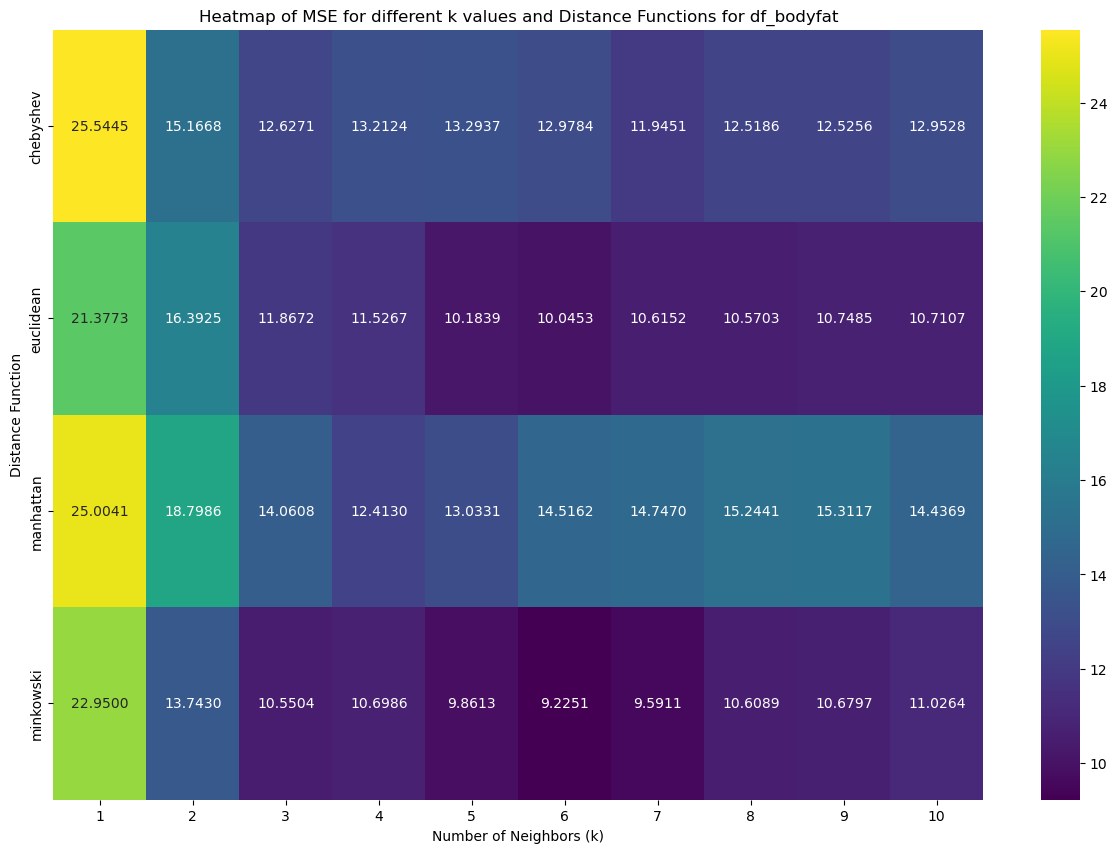

Evaluating df_ds_salary
k: 1, Distance Function: euclidean - MSE: 6114433530.696721, MAE: 53533.188524590165
k: 2, Distance Function: euclidean - MSE: 4620323436.6495905, MAE: 47691.99590163935
k: 3, Distance Function: euclidean - MSE: 4386182432.554645, MAE: 45655.3087431694
k: 4, Distance Function: euclidean - MSE: 4222929256.6116805, MAE: 45034.94672131148
k: 5, Distance Function: euclidean - MSE: 4112248137.5098357, MAE: 44917.39836065574
k: 6, Distance Function: euclidean - MSE: 4007800537.1489067, MAE: 44738.94535519125
k: 7, Distance Function: euclidean - MSE: 4015662038.478421, MAE: 45118.36533957846
k: 8, Distance Function: euclidean - MSE: 3990407149.328381, MAE: 44942.065573770495
k: 9, Distance Function: euclidean - MSE: 4024776461.5806518, MAE: 45491.870673952646
k: 10, Distance Function: euclidean - MSE: 4060131749.3718033, MAE: 45400.80163934426
k: 1, Distance Function: manhattan - MSE: 5361803278.942623, MAE: 47102.99180327869
k: 2, Distance Function: manhattan - MSE: 4

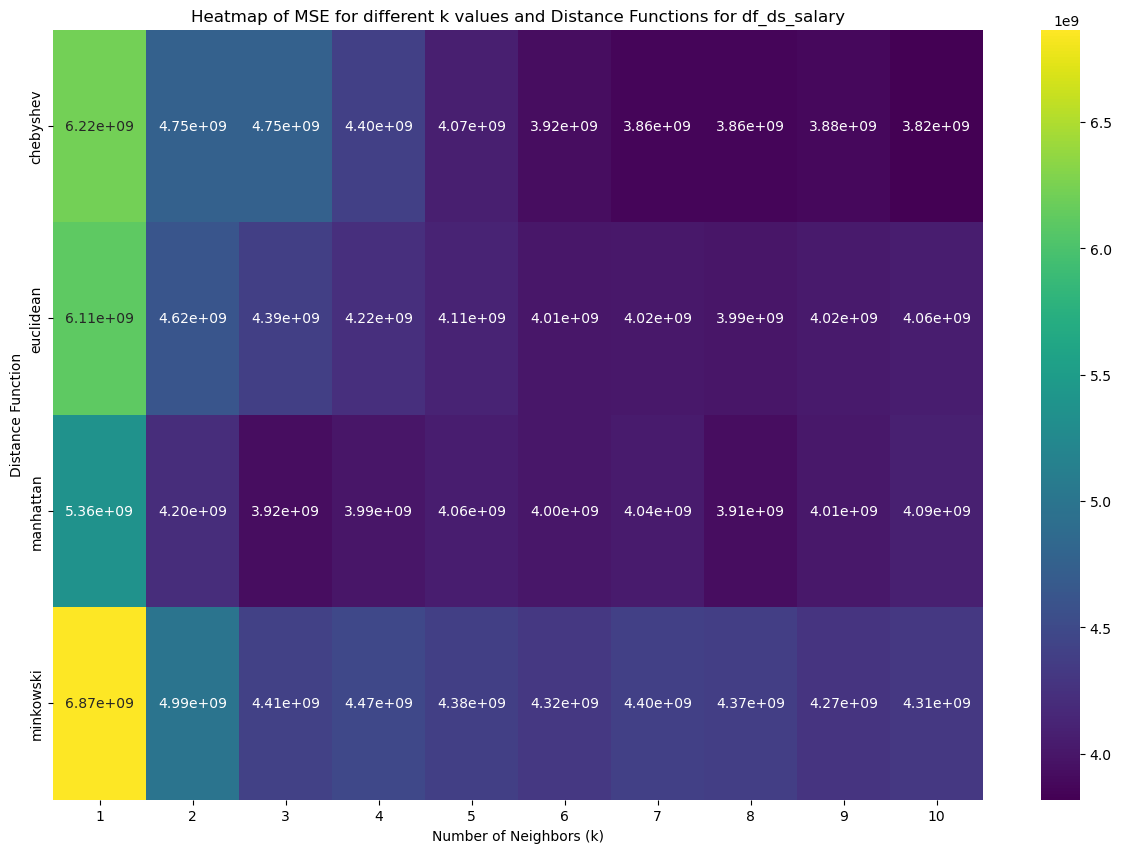

Evaluating df_CPU
k: 1, Distance Function: euclidean - MSE: 18.767541183648568, MAE: 2.8078096400244053
k: 2, Distance Function: euclidean - MSE: 15.747406955460647, MAE: 2.4917632702867603
k: 3, Distance Function: euclidean - MSE: 14.530133550267779, MAE: 2.3644498678055723
k: 4, Distance Function: euclidean - MSE: 14.644028370957901, MAE: 2.3329774252593043
k: 5, Distance Function: euclidean - MSE: 14.96170835875534, MAE: 2.3070164734594267
k: 6, Distance Function: euclidean - MSE: 15.587485594197, MAE: 2.2900142363229614
k: 7, Distance Function: euclidean - MSE: 15.620612369413902, MAE: 2.288067637060925
k: 8, Distance Function: euclidean - MSE: 16.056560784014643, MAE: 2.2869890176937155
k: 9, Distance Function: euclidean - MSE: 16.656226696495153, MAE: 2.3008609585790794
k: 10, Distance Function: euclidean - MSE: 17.606131787675412, MAE: 2.3190359975594874
k: 1, Distance Function: manhattan - MSE: 17.99267846247712, MAE: 2.7040878584502748
k: 2, Distance Function: manhattan - MSE:

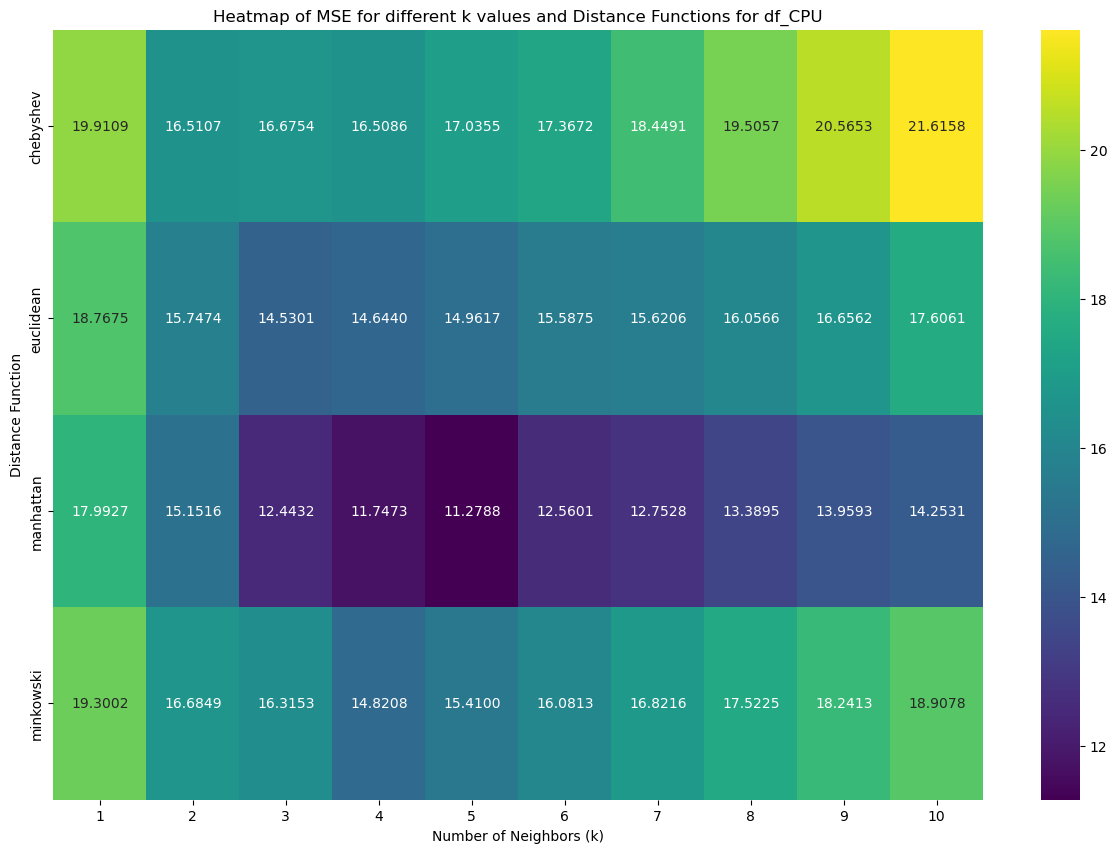

Top 5 Best Parameters: 
Bodyfat:


,k,distance_function,mse,mae
35,6,minkowski,9.2251,2.3912
36,7,minkowski,9.5911,2.3725
34,5,minkowski,9.8613,2.5294
5,6,euclidean,10.0453,2.5990
4,5,euclidean,10.1839,2.5906


Data Science Salary: 


,k,distance_function,mse,mae
29,10,chebyshev,3818103250.0835,43781.7598
27,8,chebyshev,3858311663.8947,43384.4221
26,7,chebyshev,3862431404.6922,43349.4801
28,9,chebyshev,3881252189.2844,43924.7942
17,8,manhattan,3914287063.8993,45194.4385


CPU: 


,k,distance_function,mse,mae
14,5,manhattan,11.2788,2.1267
13,4,manhattan,11.7473,2.1893
12,3,manhattan,12.4432,2.2642
15,6,manhattan,12.5601,2.1559
16,7,manhattan,12.7528,2.1632


In [19]:
# Assuming KNNRegressor is already imported and defined

# Define the range of k values
k_values = np.arange(1, 11, 1)

# List of distance functions
distance_functions = {
    'euclidean': 'euclidean',
    'manhattan': 'manhattan',
    'chebyshev': 'chebyshev',
    'minkowski': 'minkowski'
}

# Function to evaluate the model with different k values and distance functions
def evaluate_k_and_distance_functions(scaledX_train, y_train, scaledX_test, y_test, k_values, distance_functions, p_value): 
    results = []

    for name, function in distance_functions.items():
        for k_val in k_values:
            model_knn = KNNRegressor(k=k_val, distance_function=function, p=p_value) 
            model_knn.fit(scaledX_train, y_train)
            y_pred_knn = model_knn.predict(scaledX_test)

            mse_knn = mean_squared_error(y_test, y_pred_knn)
            mae_knn = mean_absolute_error(y_test, y_pred_knn)
            results.append((k_val, name, mse_knn, mae_knn))
            print(f"k: {k_val}, Distance Function: {name} - MSE: {mse_knn}, MAE: {mae_knn}")

    return results

# Initialize a list to store the best results
best_results = []

# Evaluate and plot results for each dataset
for idx, (dataset_name, (scaledX_train, y_train, scaledX_test, y_test)) in enumerate(datasets.items()):
    print(f"Evaluating {dataset_name}")
    results_knn = evaluate_k_and_distance_functions(scaledX_train, y_train, scaledX_test, y_test, k_values, distance_functions, p_value) 

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results_knn, columns=['k', 'distance_function', 'mse', 'mae'])

    # Find the top 5 parameter settings based on the lowest MSE
    best_results_df = results_df.nsmallest(5, 'mse')
    best_results.append(best_results_df)

    # Pivot the DataFrame for heatmap
    pivot_df = results_df.pivot(index='distance_function', columns='k', values='mse')

    # Plotting heatmap
    plt.figure(figsize=(15, 10))

    if (idx == 0 or idx == 2):
        # Regular formatting for the first dataset
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="viridis")
    else:
        # Scientific notation for other datasets
        sns.heatmap(pivot_df, annot=True, fmt=".2e", cmap="viridis")

    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Distance Function')
    plt.title(f'Heatmap of MSE for different k values and Distance Functions for {dataset_name}')

    plt.show()

# Concatenate the best results from all datasets
all_best_results_df = pd.concat(best_results)

# Display the top 10 results
print("Top 5 Best Parameters: ")
print("Bodyfat:")
display(best_results[0].head(5))
print("Data Science Salary: ")
display(best_results[1].head(5))
print("CPU: ")
display(best_results[2].head(5))



#### 4.1.2 Gradient Descent

##### 4.1.2.1 Iterations 

Evaluating df_bodyfat
Iterations: 50 - MSE: 28.991337018287943, MAE: 4.719808399463064
Iterations: 200 - MSE: 3.7593872915772084, MAE: 1.4225411309353813
Iterations: 350 - MSE: 3.290681089784846, MAE: 1.341639915656668
Iterations: 500 - MSE: 3.228718413873663, MAE: 1.317571562600823
Iterations: 650 - MSE: 3.242826887411197, MAE: 1.3161625041799845
Iterations: 800 - MSE: 3.2611273063518036, MAE: 1.315229061976993
Iterations: 950 - MSE: 3.273900784443917, MAE: 1.3152468007397402
Iterations: 1100 - MSE: 3.2820756273072904, MAE: 1.3143856942464702
Iterations: 1250 - MSE: 3.2875098178252435, MAE: 1.314457757079964
Iterations: 1400 - MSE: 3.29147772866763, MAE: 1.3140359568969877
Iterations: 1550 - MSE: 3.2946907322896206, MAE: 1.3134205775671046
Iterations: 1700 - MSE: 3.2975077258075305, MAE: 1.3127583556615205
Iterations: 1850 - MSE: 3.3000953279009946, MAE: 1.3121185454628794
Iterations: 2000 - MSE: 3.302523331081499, MAE: 1.3115313951109604
Evaluating df_ds_salary
Iterations: 50 - MSE: 

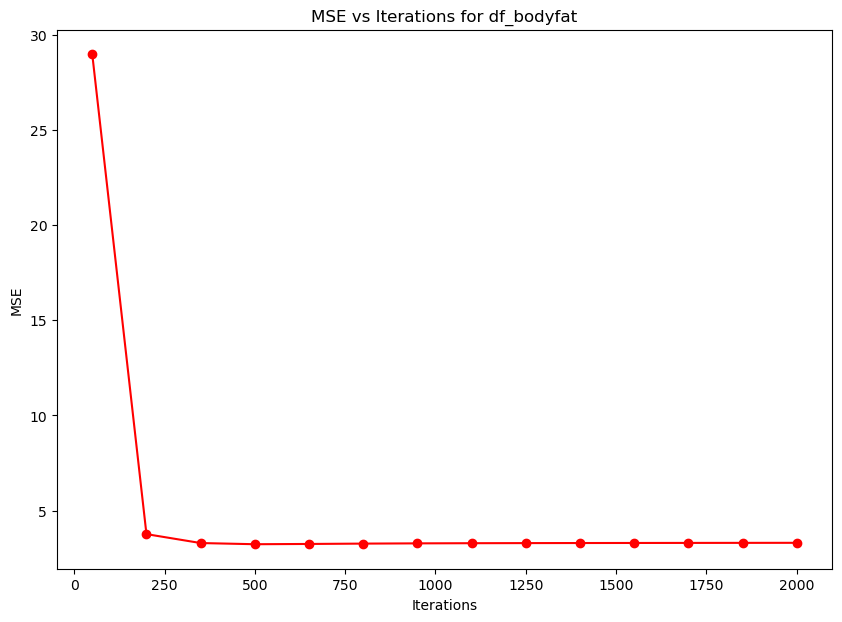

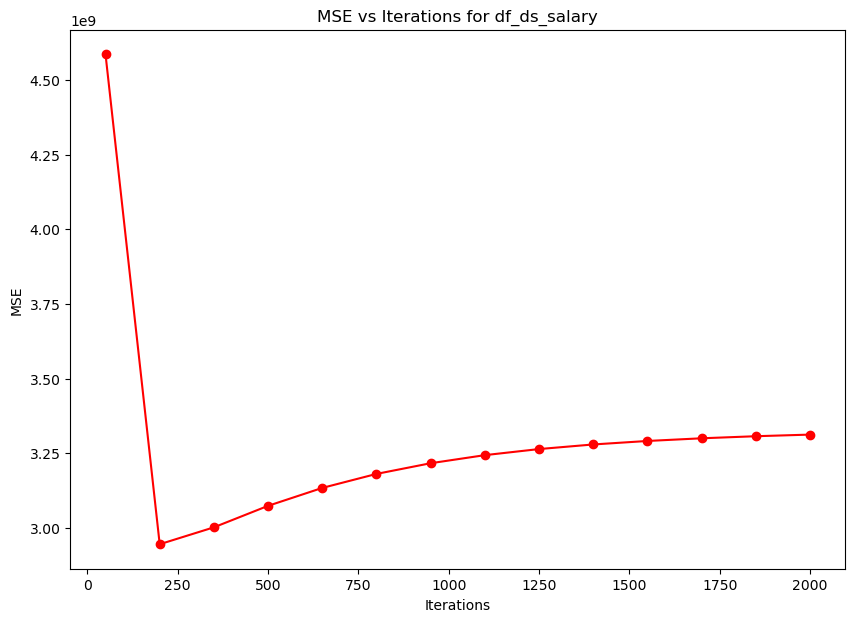

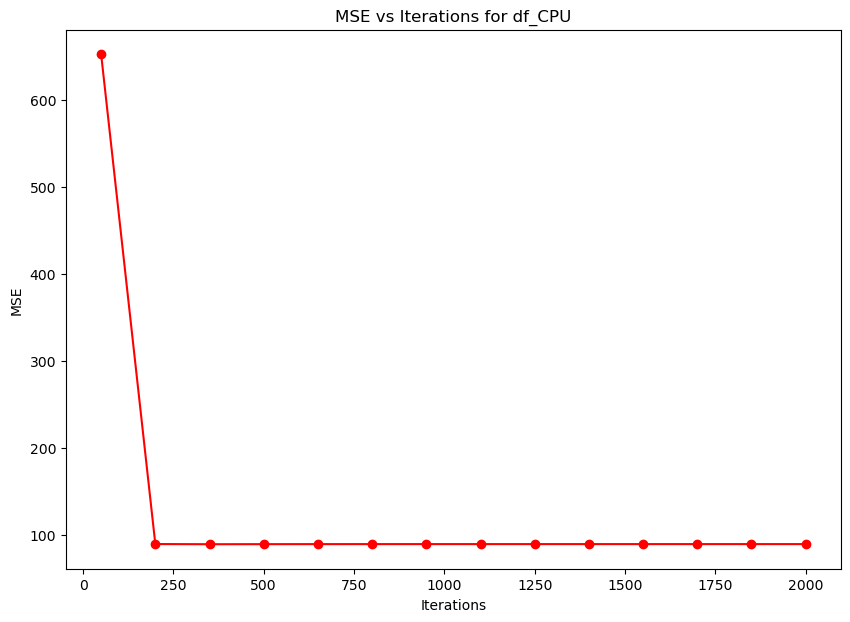

In [14]:
iterations = np.arange(50, 2001, 150) # Values from 500 to 2000 with step 150
fixed_learning_rate = 0.025  # Fixed learning rate

# Function to evaluate the model with different iterations
def evaluate_iterations(scaledX_train, y_train, scaledX_test, y_test, learning_rate, iterations):
    results = []

    for n_iter in iterations:
        model_gd = LinearRegressionGD(learning_rate=learning_rate, n_iterations=n_iter)
        model_gd.fit(scaledX_train, y_train)
        y_pred_gd = model_gd.predict(scaledX_test)

        # Check for NaN or infinite values in predictions
        if np.isnan(y_pred_gd).any() or np.isinf(y_pred_gd).any():
            print(f"Iterations: {n_iter} - Invalid prediction encountered")
            continue

        mse_gd, mae_gd = evaluate(y_test, y_pred_gd)
        results.append((n_iter, mse_gd, mae_gd))
        print(f"Iterations: {n_iter} - MSE: {mse_gd}, MAE: {mae_gd}")

    return results

# Initialize a list to store the results for all datasets
results_all_datasets = []

# Iterate over all datasets and evaluate the model with different iterations
for dataset_name, (scaledX_train, y_train, scaledX_test, y_test) in datasets.items():
    print(f"Evaluating {dataset_name}")
    results_iter = evaluate_iterations(scaledX_train, y_train, scaledX_test, y_test, fixed_learning_rate, iterations)
    results_all_datasets.append((dataset_name, results_iter))

# Plotting MSE against iterations for each dataset
for dataset_name, results_iter in results_all_datasets:
    iterations_res = [r[0] for r in results_iter]
    mse_res_iter = [r[1] for r in results_iter]

    plt.figure(figsize=(10, 7))
    plt.plot(iterations_res, mse_res_iter, 'ro-')
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.title(f'MSE vs Iterations for {dataset_name}')
    plt.show()

##### 4.1.2.1 Learning rate

Evaluating df_bodyfat
Learning Rate: 0.005 - MSE: 3.754456327002814, MAE: 1.4212675002435287
Learning Rate: 0.015263157894736843 - MSE: 3.237572013480845, MAE: 1.316181761563558
Learning Rate: 0.025526315789473685 - MSE: 3.2782257528915317, MAE: 1.3148469492409336
Learning Rate: 0.035789473684210524 - MSE: 3.2922207816456646, MAE: 1.313917891571561
Learning Rate: 0.046052631578947366 - MSE: 3.299981455348121, MAE: 1.3121492219209736
Learning Rate: 0.05631578947368421 - MSE: 3.306329428838983, MAE: 1.31068282294233
Learning Rate: 0.06657894736842106 - MSE: 3.311700297303221, MAE: 1.3096769735795737
Learning Rate: 0.0768421052631579 - MSE: 3.3161081611926653, MAE: 1.3092358335484398
Learning Rate: 0.08710526315789474 - MSE: 3.3196430806785715, MAE: 1.3094901202522329
Learning Rate: 0.09736842105263158 - MSE: 3.322446338617114, MAE: 1.309705896333245
Learning Rate: 0.10763157894736843 - MSE: 3.3246623324853863, MAE: 1.309890543874626
Learning Rate: 0.11789473684210527 - MSE: 3.32641666365

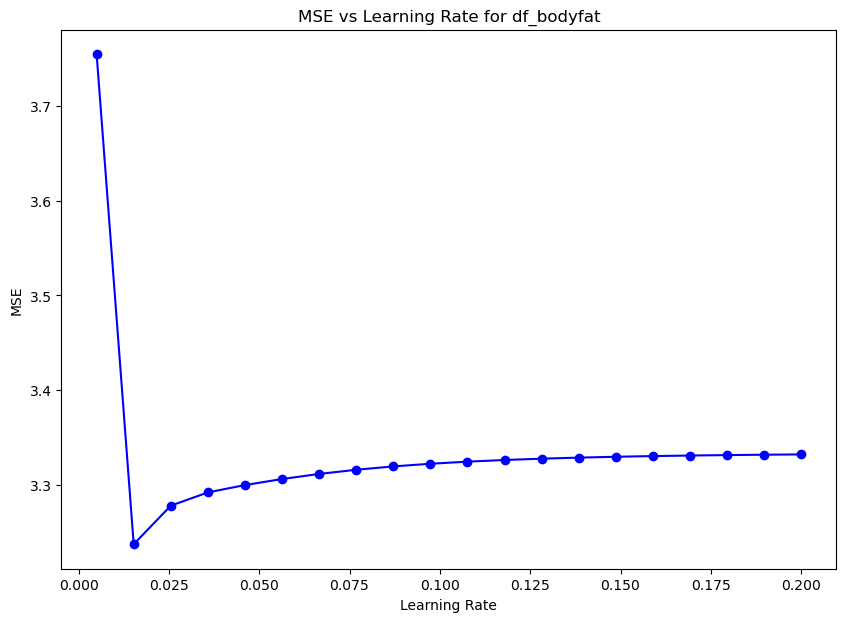

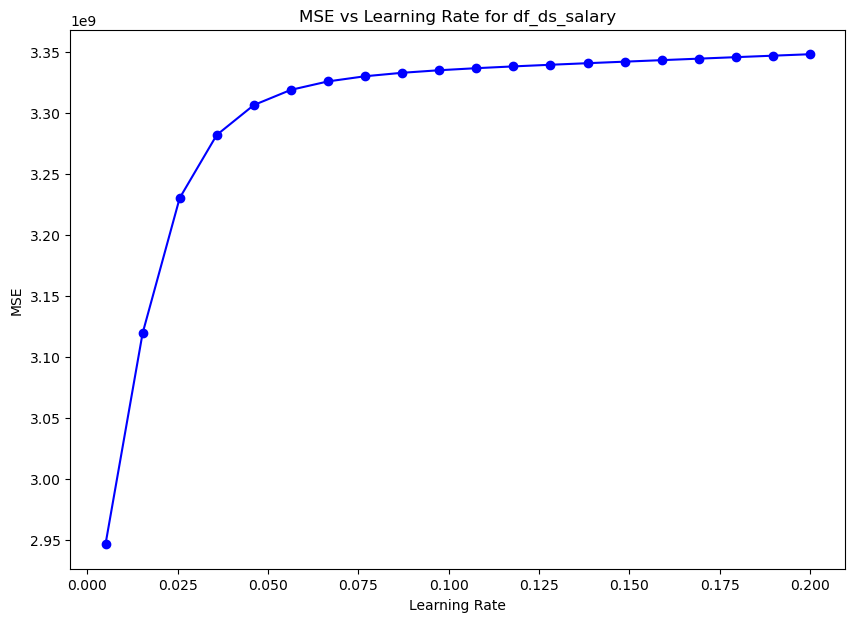

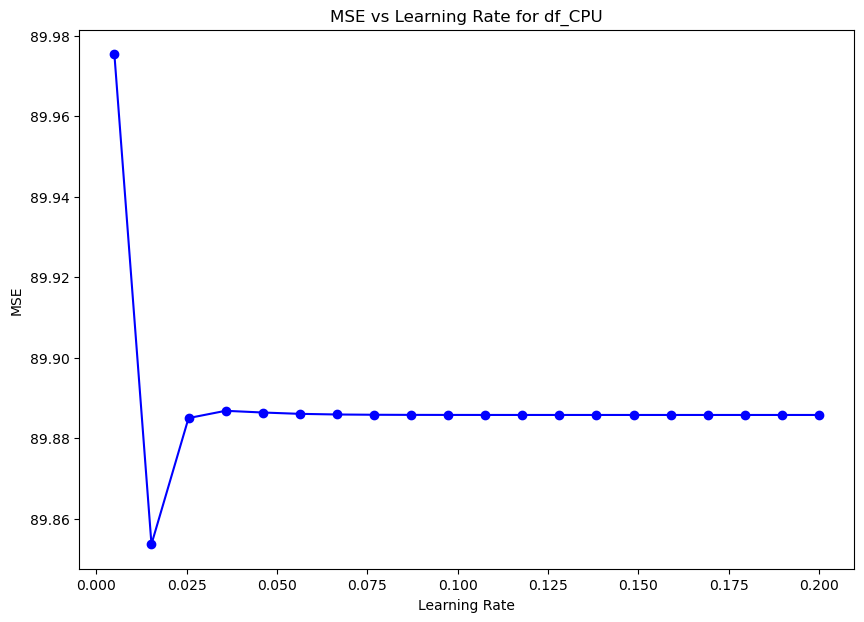

In [21]:
# Define the range of learning rates
learning_rates = np.linspace(0.005, 0.2, 20)  # 20 values from 0.005 to 0.2
fixed_iterations = 1000  # Fixed number of iterations

# Function to evaluate the model with different learning rates
def evaluate_learning_rate(scaledX_train, y_train, scaledX_test, y_test, learning_rates, n_iterations):
    results = []

    for lr in learning_rates:
        model_gd = LinearRegressionGD(learning_rate=lr, n_iterations=n_iterations)
        model_gd.fit(scaledX_train, y_train)
        y_pred_gd = model_gd.predict(scaledX_test)

        # Check for NaN or infinite values in predictions
        if np.isnan(y_pred_gd).any() or np.isinf(y_pred_gd).any():
            print(f"Learning Rate: {lr} - Invalid prediction encountered")
            continue

        mse_gd, mae_gd = evaluate(y_test, y_pred_gd)
        results.append((lr, mse_gd, mae_gd))
        print(f"Learning Rate: {lr} - MSE: {mse_gd}, MAE: {mae_gd}")

    return results

# Initialize a list to store the results for all datasets
results_all_datasets = []

# Iterate over all datasets and evaluate the model with different learning rates
for dataset_name, (scaledX_train, y_train, scaledX_test, y_test) in datasets.items():
    print(f"Evaluating {dataset_name}")
    results_lr = evaluate_learning_rate(scaledX_train, y_train, scaledX_test, y_test, learning_rates, fixed_iterations)
    results_all_datasets.append((dataset_name, results_lr))

# Plotting MSE against learning rates for each dataset
for dataset_name, results_lr in results_all_datasets:
    learning_rates_res = [r[0] for r in results_lr]
    mse_res_lr = [r[1] for r in results_lr]

    plt.figure(figsize=(10, 7))
    plt.plot(learning_rates_res, mse_res_lr, 'bo-')
    plt.xlabel('Learning Rate')
    plt.ylabel('MSE')
    plt.title(f'MSE vs Learning Rate for {dataset_name}')
    plt.show()


##### 4.1.2.1 Learning rate and iterations

Evaluating df_bodyfat
Iterations: 50, Learning rate: 0.005 - MSE: 217.60781288128177, MAE: 14.143344242439476
Iterations: 200, Learning rate: 0.005 - MSE: 47.56270057658226, MAE: 6.214063172029381
Iterations: 350, Learning rate: 0.005 - MSE: 12.895001209974007, MAE: 3.0350389827320647
Iterations: 500, Learning rate: 0.005 - MSE: 5.899780639594362, MAE: 2.021003603954763
Iterations: 650, Learning rate: 0.005 - MSE: 4.442285563516725, MAE: 1.6467647249329975
Iterations: 800, Learning rate: 0.005 - MSE: 4.031576475383538, MAE: 1.5026484456657994
Iterations: 950, Learning rate: 0.005 - MSE: 3.8137251088844066, MAE: 1.4329595023200967
Iterations: 50, Learning rate: 0.02666666666666667 - MSE: 24.864988981614157, MAE: 4.3526751807981885
Iterations: 200, Learning rate: 0.02666666666666667 - MSE: 3.6860914845196118, MAE: 1.4073338441300245
Iterations: 350, Learning rate: 0.02666666666666667 - MSE: 3.2678145953454245, MAE: 1.3334824456384762
Iterations: 500, Learning rate: 0.02666666666666667 - 

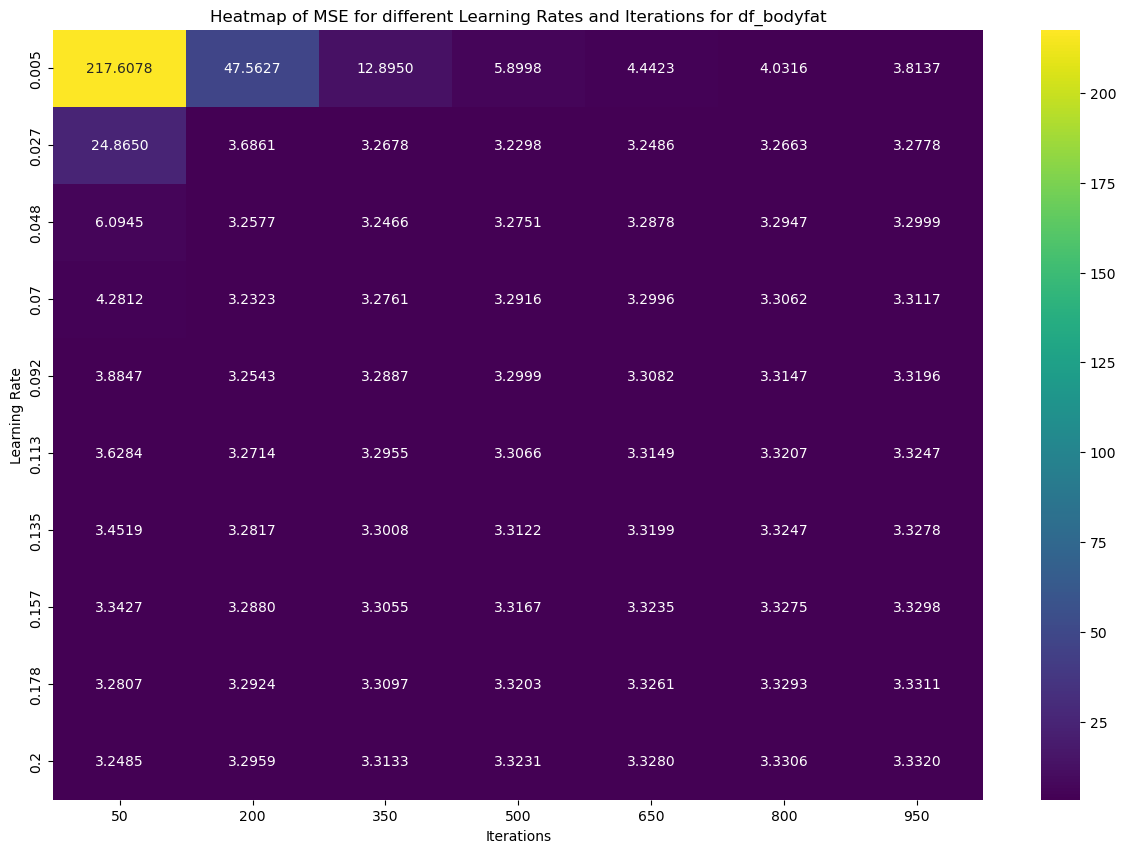

Evaluating df_ds_salary
Iterations: 50, Learning rate: 0.005 - MSE: 12747044202.892017, MAE: 96949.66249917875
Iterations: 200, Learning rate: 0.005 - MSE: 5492286629.865462, MAE: 54046.66261351141
Iterations: 350, Learning rate: 0.005 - MSE: 3696948412.1721153, MAE: 40810.89935511456
Iterations: 500, Learning rate: 0.005 - MSE: 3184759117.787058, MAE: 37570.570504090974
Iterations: 650, Learning rate: 0.005 - MSE: 3019774140.854354, MAE: 36909.84256050147
Iterations: 800, Learning rate: 0.005 - MSE: 2963551045.00697, MAE: 36886.714774022075
Iterations: 950, Learning rate: 0.005 - MSE: 2947289320.916843, MAE: 36990.04552679477
Iterations: 50, Learning rate: 0.02666666666666667 - MSE: 4371805266.433094, MAE: 45680.49393740844
Iterations: 200, Learning rate: 0.02666666666666667 - MSE: 2946202679.7696676, MAE: 37075.35868613744
Iterations: 350, Learning rate: 0.02666666666666667 - MSE: 3013638126.7958736, MAE: 37785.02103127615
Iterations: 500, Learning rate: 0.02666666666666667 - MSE: 30

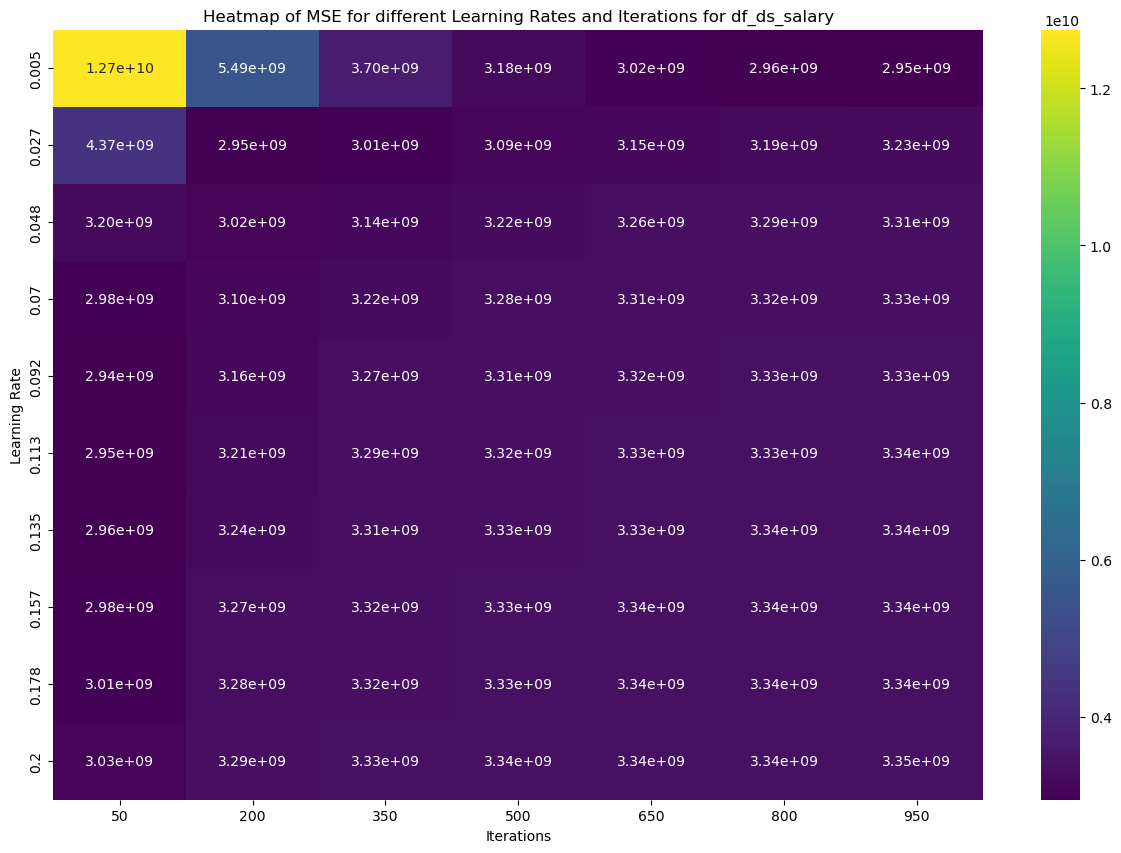

Evaluating df_CPU
Iterations: 50, Learning rate: 0.005 - MSE: 4435.369330121451, MAE: 65.40013640046097
Iterations: 200, Learning rate: 0.005 - MSE: 1045.7084080799448, MAE: 31.722372660257488
Iterations: 350, Learning rate: 0.005 - MSE: 300.6998215144649, MAE: 16.03324821486559
Iterations: 500, Learning rate: 0.005 - MSE: 136.1636260419549, MAE: 9.15168823050355
Iterations: 650, Learning rate: 0.005 - MSE: 99.8850661875245, MAE: 6.701483066737212
Iterations: 800, Learning rate: 0.005 - MSE: 91.91287963243929, MAE: 6.030387692751137
Iterations: 950, Learning rate: 0.005 - MSE: 90.16859027705192, MAE: 5.892636005355671
Iterations: 50, Learning rate: 0.02666666666666667 - MSE: 563.940715489639, MAE: 22.95495469812421
Iterations: 200, Learning rate: 0.02666666666666667 - MSE: 89.82093401767457, MAE: 5.874188328380669
Iterations: 350, Learning rate: 0.02666666666666667 - MSE: 89.75896679134961, MAE: 5.964865524550667
Iterations: 500, Learning rate: 0.02666666666666667 - MSE: 89.83385601728

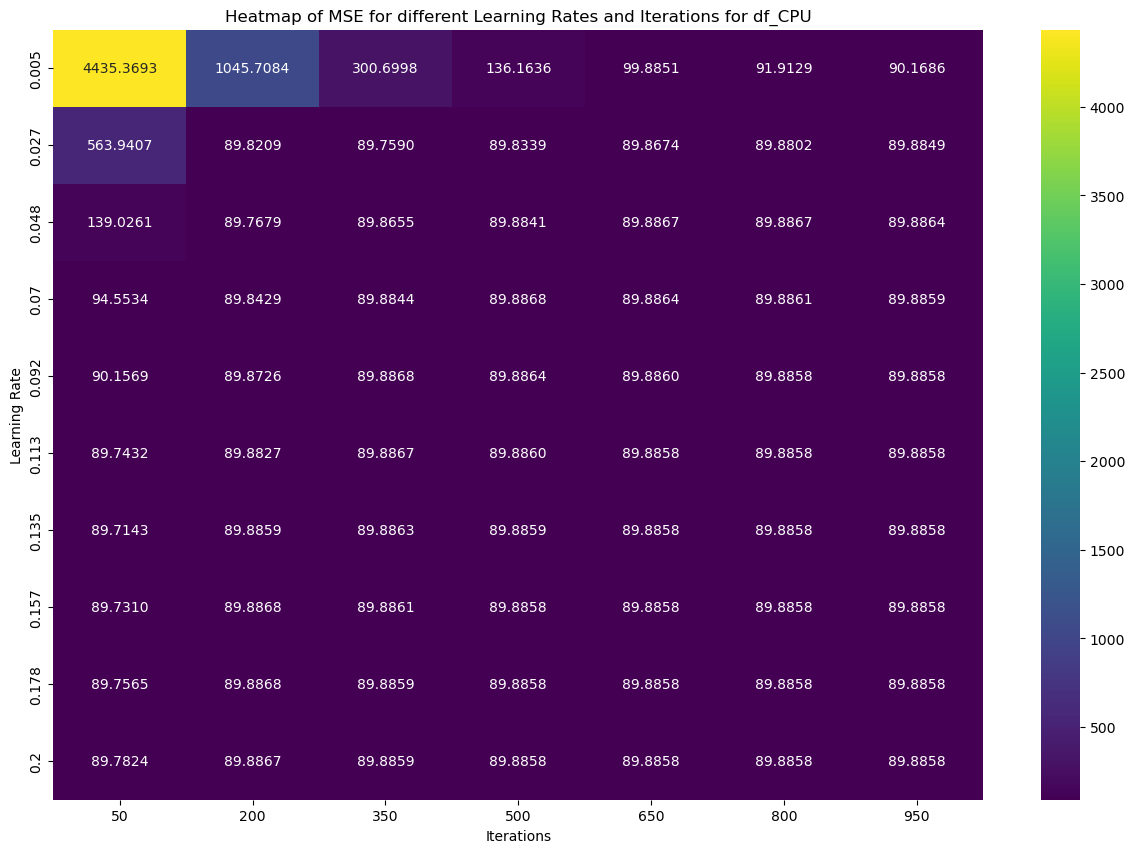

Top 5 Best Parameters for df_bodyfat:


,Iterations,Learning Rate,MSE,MAE
10,500,0.0267,3.2298,1.3169
22,200,0.0700,3.2323,1.3169
16,350,0.0483,3.2466,1.3162
63,50,0.2000,3.2485,1.3253
11,650,0.0267,3.2486,1.3161


Top 5 Best Parameters for df_ds_salary:


,Iterations,Learning Rate,MSE,MAE
28,50,0.0917,2943874253.0709,36963.3937
8,200,0.0267,2946202679.7697,37075.3587
35,50,0.1133,2947122889.0168,37135.5355
6,950,0.0050,2947289320.9168,36990.0455
5,800,0.0050,2963551045.0070,36886.7148


Top 5 Best Parameters for df_CPU:


,Iterations,Learning Rate,MSE,MAE
42,50,0.1350,89.7143,5.9081
49,50,0.1567,89.7310,5.9383
35,50,0.1133,89.7432,5.8750
56,50,0.1783,89.7565,5.9615
9,350,0.0267,89.7590,5.9649


In [15]:
learning_rates = np.linspace(0.005, 0.2, 10)  # 10 values from 0.005 to 0.2
iterations = np.arange(50, 1000, 150)  # Values from 50 to 1000 with step 150

def evaluate_learning_rates_and_iterations(scaledX_train, y_train, scaledX_test, y_test, learning_rates, iterations):
    results = []
    for rate in learning_rates:
        for i in iterations:
            model = LinearRegressionGD(learning_rate=rate, n_iterations=i)
            model.fit(scaledX_train, y_train)
            y_pred = model.predict(scaledX_test)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            results.append((i, rate, mse, mae))
            print(f"Iterations: {i}, Learning rate: {rate} - MSE: {mse}, MAE: {mae}")
    return results

best_results = []
for idx, (dataset_name, (scaledX_train, y_train, scaledX_test, y_test)) in enumerate(datasets.items()):
    print(f"Evaluating {dataset_name}")
    results = evaluate_learning_rates_and_iterations(scaledX_train, y_train, scaledX_test, y_test, learning_rates, iterations)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Iterations', 'Learning Rate', 'MSE', 'MAE'])

    # Find the top 5 parameter settings based on the lowest MSE
    best_results_df = results_df.nsmallest(5, 'MSE')
    best_results.append(best_results_df)

    # Pivot the DataFrame for heatmap
    pivot_df = results_df.pivot(index='Learning Rate', columns='Iterations', values='MSE')
    #pivot_df.index = pivot_df['Learning Rate']

    # Round the learning rate values on the heatmap DataFrame to two decimals
    pivot_df.index = pivot_df.index.to_series().round(3) 

    # Plotting heatmap
    plt.figure(figsize=(15, 10))

    if (idx == 0 or idx == 2):
        # Regular formatting for the first dataset
        sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="viridis")
    else:
        # Scientific notation for other datasets
        sns.heatmap(pivot_df, annot=True, fmt=".2e", cmap="viridis")
    
    plt.xlabel('Iterations')
    plt.ylabel('Learning Rate')
    plt.title(f'Heatmap of MSE for different Learning Rates and Iterations for {dataset_name}')
    plt.show()

# Concatenate the best results from all datasets
all_best_results_df = pd.concat(best_results)

# Display the top 5 results for each dataset
for idx, dataset_name in enumerate(datasets):
    print(f"Top 5 Best Parameters for {dataset_name}:")
    display(best_results[idx].head(5))

### 4.2 Comparison with other algorithms

In [16]:
models = {
    "KNNRegressor (implemented)": KNNRegressor(),
    "KNeighborsRegressor (sklearn)": KNeighborsRegressor(),
    "Gradient Descent Linear Regression (implemented)": LinearRegressionGD(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
}
for dataset_name, (X_train, y_train, X_test, y_test) in datasets.items():
    results = []
    for name, model in models.items():
        start_time_fit = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time_fit
        start_time_predict = time.time()
        y_pred = model.predict(X_test)
        predict_time = time.time() - start_time_predict
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results.append({
            "Model": name,
            "Fit Time": fit_time,
            "Predict Time": predict_time,
            "MSE": mse,
            "MAE": mae
        })
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='MSE', ascending=True)
    print(f"Results for Dataset: {dataset_name}")
    display(results_df)
    print("\n")


Results for Dataset: df_bodyfat


,Model,Fit Time,Predict Time,MSE,MAE
5,Lasso Regression,0.0020,0.0000,2.2344,0.9044
4,Ridge Regression,0.0080,0.0042,3.2444,1.2905
2,Gradient Descent Linear Regression (implemented),0.1815,0.0000,3.2501,1.3263
3,Linear Regression,0.1037,0.0000,3.3338,1.3109
7,Gradient Boosting,0.1169,0.0000,3.7106,1.3753
6,Random Forest,0.2815,0.0172,3.7147,1.4241
0,KNNRegressor (implemented),0.0001,0.0513,10.1839,2.5906
1,KNeighborsRegressor (sklearn),0.0142,0.0030,10.1839,2.5906


c:\Users\kpriselac\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.649e+10, tolerance: 2.442e+08
  model = cd_fast.enet_coordinate_descent(


Results for Dataset: df_ds_salary


,Model,Fit Time,Predict Time,MSE,MAE
7,Gradient Boosting,0.1000,0.0000,2985655156.9909,38471.5790
2,Gradient Descent Linear Regression (implemented),0.2433,0.0000,3026708625.0197,37891.3632
6,Random Forest,0.3881,0.0127,3175020807.3405,37033.9767
4,Ridge Regression,0.0007,0.0000,3329140241.1612,39845.0351
5,Lasso Regression,0.0858,0.0000,3493793883.7195,41298.2158
0,KNNRegressor (implemented),0.0000,0.4374,4112248137.5098,44917.3984
1,KNeighborsRegressor (sklearn),0.0037,0.3330,4306571571.5826,47221.9754
3,Linear Regression,0.0297,0.0085,7723176901745468343867727909434163200.0000,1402629090629009920.0000




Results for Dataset: df_CPU


,Model,Fit Time,Predict Time,MSE,MAE
6,Random Forest,12.6311,0.0763,8.8325,2.1693
7,Gradient Boosting,3.4812,0.0000,12.1256,2.4324
0,KNNRegressor (implemented),0.0000,68.1559,14.9617,2.3070
1,KNeighborsRegressor (sklearn),0.0101,0.1037,14.9617,2.3070
2,Gradient Descent Linear Regression (implemented),0.3657,0.0000,89.7738,5.9746
3,Linear Regression,0.0000,0.0074,89.8858,6.0230
4,Ridge Regression,0.0043,0.0000,89.8872,6.0223
5,Lasso Regression,0.0000,0.0000,97.9124,5.9505
